In [1]:
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv("../data/fulldata.csv")
df2 = pd.read_csv("../data/6_14_pull.csv")

df = pd.concat([df,df2])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from Cleaning import lowercase, unpunctuate, tokenize, lemmatize, count_capitalized_words, create_other_var, cleaning_and_prep, stack_vectors

In [3]:
X_train, X_test, y_train, y_test = cleaning_and_prep(df)

C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Conservative',0)


In [4]:
X_train_vec, X_test_vec, X_train, X_test = stack_vectors(X_train,X_test)

In [12]:
X_train_vec = np.reshape(X_train_vec, (X_train_vec.shape[0], 100, 1))
X_test_vec = np.reshape(X_test_vec, (X_test_vec.shape[0], 100, 1))

Epoch 1/100
763/763 [==============================] - 75s 95ms/step - loss: 0.6411 - accuracy: 0.6257 - auc: 0.6824 - val_loss: 0.5912 - val_accuracy: 0.6819 - val_auc: 0.7681
Epoch 2/100
763/763 [==============================] - 73s 96ms/step - loss: 0.5843 - accuracy: 0.6799 - auc: 0.7549 - val_loss: 0.5581 - val_accuracy: 0.7137 - val_auc: 0.7907
Epoch 3/100
763/763 [==============================] - 74s 97ms/step - loss: 0.5673 - accuracy: 0.6973 - auc: 0.7743 - val_loss: 0.5595 - val_accuracy: 0.7158 - val_auc: 0.7967
Epoch 4/100
763/763 [==============================] - 76s 99ms/step - loss: 0.5600 - accuracy: 0.7021 - auc: 0.7817 - val_loss: 0.5513 - val_accuracy: 0.7256 - val_auc: 0.7986
Epoch 5/100
763/763 [==============================] - 76s 99ms/step - loss: 0.5533 - accuracy: 0.7077 - auc: 0.7876 - val_loss: 0.5426 - val_accuracy: 0.7214 - val_auc: 0.8039
Epoch 6/100
763/763 [==============================] - 73s 96ms/step - loss: 0.5476 - accuracy: 0.7115 - auc: 0.791

<Axes: >

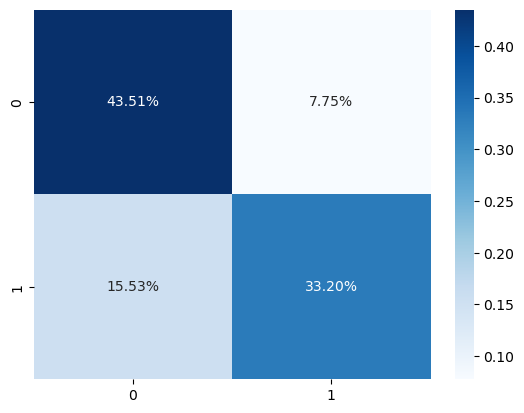

In [13]:
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, concatenate, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score

# First branch for the CNN and LSTM
cnn_input = Input(shape=(100, 1))
cnn_output = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_output = MaxPooling1D(pool_size=2)(cnn_output)
cnn_output = LSTM(units=256, return_sequences=True, activation='relu')(cnn_output)
cnn_output = Dropout(0.2)(cnn_output)
cnn_output = LSTM(units=128, activation='relu')(cnn_output)
cnn_output = Dropout(0.2)(cnn_output)

# Second branch for the dense layers
dense_input = Input(shape=(5,))
dense_output = Dense(units=64, activation='relu')(dense_input)
dense_output = Dropout(0.2)(dense_output)

# Concatenate the outputs from both branches
combined = concatenate([cnn_output, dense_output])

combined = Dense(units = 64, activation='relu')(combined)

# Final output layer
output = Dense(units=1, activation='sigmoid')(combined)

# Create the model
model = Model(inputs=[cnn_input, dense_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with both LSTM and dense input
model.fit([X_train_vec, X_train], y_train, epochs=100, batch_size=32,
          validation_data=([X_test_vec, X_test], y_test),
          callbacks=[early_stopping])

# Predict and evaluate
y_pred = model.predict([X_test_vec, X_test])
roc_auc = roc_auc_score(y_test, y_pred)

y_pred_class = (y_pred > .5).astype(int)
accuracy = accuracy_score(y_test,y_pred_class)
print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred_class)

sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
#model containing character length, number of capital words, upvotes and # of comments
#Model 2 adds POS tagging and standard scaling of variables
#Only left in proper nouns as others decreased performance

In [ ]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

#create extra variables for later
df_other_var = create_other_var(df)

#Create simple dataframe with only text and predictor
df = df[['Title','Political Lean']] 

#dummy code predictor
df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
df['Political Lean'] = df['Political Lean'].replace('Conservative',0)

df = df.rename({'Political Lean':'y'},axis=1) #replace column name for simplicity

df = pd.concat([df,df_other_var],axis=1)

df = df[df['Length']>=15]

#Split into X & y
X = df.drop(['y'],axis=1)
y = df['y']

#oversample minority class
oversample = RandomOverSampler(sampling_strategy='minority', random_state=13)
X, y = oversample.fit_resample(X, y)

In [ ]:
loss_df = X_test.merge(X[['Title']],left_index=True,right_index=True,how='left')
loss_df = loss_df.merge(y,left_index=True,right_index=True,how='left')
predictions = pd.DataFrame(y_pred, columns = ['prob'])
loss_df = pd.concat([loss_df,predictions.set_index(loss_df.index)],axis=1)
loss_df['prob'] = abs(loss_df['prob']-.5)

In [ ]:
loss_df.sort_values(by='prob').head(50)